In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
sub = pd.read_csv("./data/sample_submission.csv")
sub.describe()
sub["item_cnt_month"].value_counts()

0.5    214200
Name: item_cnt_month, dtype: int64

In [3]:
items = pd.read_csv("./data/items.csv")
items.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


In [4]:
categories = pd.read_csv("./data/categories.csv")
categories.head()

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [5]:
shops = pd.read_csv("./data/shops.csv")
shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4


In [6]:
training_data = pd.read_csv("./data/sales_train.csv")
training_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
columns = training_data.columns
print(columns)
training_data["item_price"][training_data["item_id"] == 2552].value_counts()


Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


949.0    7
899.0    2
Name: item_price, dtype: int64

# EDA
Basic things about the data
 - `items` :
    - category_id is not unique
    - item_id is a unique number
    - item_name is the human text for above
 - `categories` :
    - category_id is a unique number
    - category_name is the human text for above
 - `shops` :
    - shop_id is a unique number
    - shop_name is the human text for above
 - `training_data` :
    - item_price isn't always the same for the same item_id! Sales do exist
    - date_block_num is the month the data is from (Jan 2013 is 0, Oct 2015 is 33)
    - item_cnt_day is products sold, this is our target. We are predicting a MONTHLY value though
- Submission: test.csv has ID which is (Shop ID, Item ID), submissions are a prediction for each of those

## Thoughts
- A Haggling score could be useful as I have noticed that identical items are sold for different prices
- Refunds do also exist (negative prices) which may also be important
- Might be worth breaking a month into weeks, making a prediction for each and then using the average

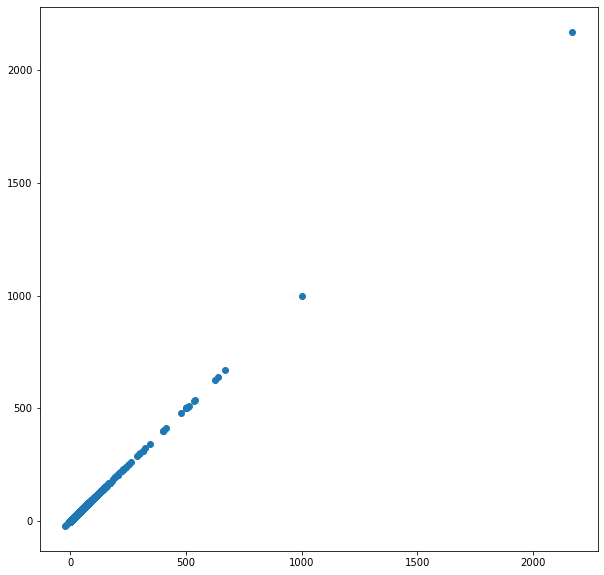

In [75]:
plt.figure(figsize=(10,10))
# This shows that some items had ridiculous sales numbers
#sb.boxplot(x=training_data.item_cnt_day)
plt.scatter(x=training_data["item_cnt_day"],y=training_data["item_cnt_day"])

### Practice: Build a "Lagged Value" prediction
The predictions here are just the monthly sales from previous month
(Also limited to the [0,20] range)

In [8]:
df = training_data
print(df.columns)
# So to build a lagged data prediction, we need to have just one month of data
# Then copy that info to be our "prediction"
month = df[df["date_block_num"] == 33]
month = month.drop(columns= ["date","date_block_num", "item_price"])
month.head()

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


,shop_id,item_id,item_cnt_day
2882335,45,13315,1.0
2882336,45,13880,1.0
2882337,45,13881,1.0
2882338,45,13881,1.0
2882339,45,13923,1.0


In [9]:
test = pd.read_csv("./data/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
# #test["prediction"] = month["item_cnt_day"][month["shop_id"] == test["shop_id"] and month["item_id"] == test["item_id"]]
# results = pd.DataFrame()
# for row in test["ID"]:
#     #print(test["shop_id"][row])
#     shop = test["shop_id"][row]
#     item = test["item_id"][row]
#     subdata = month[month["shop_id"] == shop]
#     results.append(subdata[subdata["item_id"] == item])
#
# results.head()
# #test.head()

In [15]:
groups = month.groupby(["shop_id", "item_id"])
columns = ["shop_id", "item_id", "prediction"]
results = pd.DataFrame(columns=columns)

for group, data in groups:
    # print(group)
    # print(data["item_cnt_day"].sum())
    shopid = int(data["shop_id"].mean())
    itemid = int(data["item_id"].mean())
    pred = data["item_cnt_day"].sum()
    #row_to_add = [shopid, itemid, pred]
    data = [{"shop_id":shopid, "item_id":itemid, "prediction":pred}]

    results = results.append(data)
    #print(results)
    # print(shopid)
    # print(itemid)
    # print(pred)

    #print("=====")

results.head()

,shop_id,item_id,prediction
0,2,31,1.0
0,2,486,3.0
0,2,787,1.0
0,2,794,1.0
0,2,968,1.0


In [45]:
# Non awful method, thanks Javier
df = training_data
print(df.columns)
# So to build a lagged data prediction, we need to have just one month of data
# Then copy that info to be our "prediction"
month = df[df["date_block_num"] == 33]
#month = month.drop(columns= ["date","date_block_num", "item_price"])
final = month.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
final.head()

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0


In [52]:
df = results
# merge is a very useful method here, much easier than the insane method I was doing (open each file and match the ids etc etc)
# Literally one easy to read command
submission = pd.merge(left = test, # The dataframe on the left (The one we want to add our results to)
                      right = df, # The results to add to it
                      on=["shop_id", "item_id"], # How we want to have the results added
                      how="left") # Tell pandas the left one is the base

# And it's built
submission.head()

,ID,shop_id,item_id,prediction
0,0,5,5037,NaN
1,1,5,5320,NaN
2,2,5,5233,1.0
3,3,5,5232,NaN
4,4,5,5268,NaN


,item_cnt_month
ID,
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [72]:
# Has a lot of Nans though
#submission.isnull().sum()
# Fill NaNs with 0s
submission["prediction"] = submission["prediction"].fillna(0)
# Done
#submission.head()

# Need to squish our values into range [0 to 20]
#submission.prediction.describe()
submission.prediction = submission.prediction.clip(lower=0, upper=20)
#submission.describe()

# Finally tidy up for submission
submission["item_cnt_month"] = submission["prediction"]
renamed = submission.drop(columns=["shop_id", "item_id","prediction"])
#renamed = renamed.drop(columns="ID")
renamed.index = renamed.ID
renamed = renamed.drop(columns="ID")
#renamed.head()
renamed.to_csv("lag-predictor.csv", index_label="ID")